In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [86]:
class Dense:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([units,1]), name=(name + '_b'))
        self.activation = activation

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b
        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [87]:
class Batch_norm:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W')) 
        self.activation = activation

        self.gamma = tf.Variable(tf.ones([units, 1]), name=(name + '_gamma'))
        self.beta = tf.Variable(tf.ones([units, 1]), name=(name + '_beta'))
        self.mu_test = tf.Variable(tf.zeros([units,1]))
        self.sigma_test = tf.Variable(tf.ones([units,1]))

    def forward(self, X, training):
        e = 10**-8

        Z = tf.linalg.matmul(self.W,X)

        if training:
            mu = tf.math.reduce_mean(Z, axis=1, keepdims=True)
            sigma = tf.math.reduce_variance(Z - mu, axis=1, keepdims=True)
            sigma = tf.math.sqrt(sigma + e)

            self.mu_test.assign(0.95*self.mu_test + 0.05*mu)
            self.sigma_test.assign(0.95*self.sigma_test + 0.05*sigma)
        else:
            mu = self.mu_test
            sigma = self.sigma_test

        Z = (Z - mu) / sigma
        Z = self.gamma * Z + self.beta

        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.gamma, self.beta]

In [88]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, X, training):
        if not training:
            return X
        X = tf.nn.dropout(X, 1-self.keep_prob)
        # D = tf.random.uniform(tf.shape(X)) < self.keep_prob
        # D = tf.cast(D, dtype=tf.float32)
        # X = X * D
        # X = X / self.keep_prob
        return X

    def get_vars(self):
        return None

In [89]:
class Softmax:
    def __init__(self, classes, input_size, name):
        self.classes = classes

        self.W = tf.Variable(tf.random.normal([classes, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([classes,1]), name=(name + '_b'))

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b

        T = tf.math.exp(Z)
        A = T / tf.math.reduce_sum(T, axis=0)
        return A

    def get_vars(self):
        return [self.W, self.b]

In [114]:
class Model:
    def __init__(self, layer_names, units, input_size, cost_function):
        self.layers = self.__create_layers__(layer_names, units, input_size)
        self.cost = cost_function

    @tf.function
    def forward(self, X, training=False):
        for layer in self.layers:
            X = layer.forward(X, training)
        return X

    @tf.function
    def train(self, X_batches_train, Y_batches_train, X_dev, Y_dev, optimizer):
        print('Traceing...')
        #training
        cost_train = 0.
        i = 0
        for X_train, Y_train in zip(X_batches_train, Y_batches_train):       
            cost = self.__training_step__(X_train, Y_train, optimizer)
            cost_train = (cost_train * i + cost) / (i+1)
            i += 1

        #validation
        prediction = self.forward(X_dev, training=False)
        cost_dev = self.cost(Y_dev, prediction) 

        return cost_train, cost_dev

    @tf.function
    def __training_step__(self, X_train, Y_train, optimizer):
        with tf.GradientTape() as tape:
            variables = self.__get_variables__()
            tape.watch(variables)
            prediction = self.forward(X_train, training=True)
            cost = self.cost(Y_train, prediction)
            grads = tape.gradient(cost, variables)
        optimizer.apply_gradients(grads, variables)
        return cost

    def __get_variables__(self):
        variables = []
        for layer in self.layers:
            var = layer.get_vars()
            if var != None:
                variables += var
        return variables

    def __create_layers__(self, layer_names, units, input_size):
        units.insert(0, input_size)
        layers = []
        i = 1

        for layer_name in layer_names:
            if layer_name == 'dense':
                layer = Dense(units[i], units[i-1], tf.nn.sigmoid, 'Dense' + str(i))
                layers.append(layer)
                i += 1

            elif layer_name == 'batch_norm':
                layer = Batch_norm(units[i], units[i-1], tf.nn.sigmoid, 'Batch_norm' + str(i))
                layers.append(layer)
                i += 1

            elif layer_name == 'dropout':
                layer = Dropout(keep_prob)
                layers.append(layer)

            elif layer_name == 'softmax':  
                layer = Softmax(units[i], units[i-1], 'Dense' + str(i))
                layers.append(layer)
                i += 1

        return layers 

In [91]:
class Adam:
    def __init__(self, learning_rate, beta_v = 0.9, beta_s = 0.999):
        self.v = []
        self.s = []
        self.iteration = 0
        self.learning_rate = learning_rate
        self.beta_v = beta_v
        self.beta_s = beta_s

    def apply_gradients(self, grads, variables):
        self.iteration += 1

        for i in range(len(grads)):
            if len(self.v) <= i:
                self.v.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))
            if len(self.s) <= i:
                self.s.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))

            self.v[i].assign(self.beta_v*self.v[i] + (1-self.beta_v)*grads[i])
            v_corrected = self.v[i] / (1 - tf.math.pow(self.beta_v,self.iteration))

            self.s[i].assign(self.beta_s*self.s[i] + (1-self.beta_s)* tf.math.square(grads[i]))
            s_corrected = self.s[i] / (1 - tf.math.pow(self.beta_s,self.iteration))

            change = self.learning_rate * (v_corrected/(tf.math.sqrt(s_corrected) + 10**-8))

            variables[i].assign_add(-change)

In [92]:
def Loss(Y, A):
    loss = tf.math.log(A)
    loss = Y * loss
    loss = -tf.math.reduce_sum(loss, axis=0)
    return loss

In [93]:
def Cost(Y, A):
    losses = Loss(Y, A)
    cost = tf.reduce_mean(losses)
    return cost

In [94]:
def create_batches(data, batch_size):
    mini_batches = []
    n = int(data.shape[1] / batch_size)
    for i in range(n):
        mini_batches.append(data[:,i*batch_size:(i+1)*batch_size])
    mini_batches.append(data[:,-(data.shape[1] % batch_size):])
    return mini_batches

In [196]:
def get_training_data(batch_size):
    (x_train, y_train), (x_dev, y_dev) = tf.keras.datasets.mnist.load_data()
    x_train = x_train / 255
    x_dev = x_dev / 255
    y_train = tf.one_hot(y_train, depth=10, axis=0)
    y_dev = tf.one_hot(y_dev, depth=10, axis=0)

    x_train = tf.reshape(x_train, [-1, image_height*image_width])
    x_train = tf.linalg.matrix_transpose(x_train)
    x_train = tf.cast(x_train, tf.float32)

    x_dev = tf.reshape(x_dev, [-1, image_height*image_width])
    x_dev = tf.linalg.matrix_transpose(x_dev)
    x_dev = tf.cast(x_dev, tf.float32)

    x_train = x_train[:,:100000]
    y_train = y_train[:,:100000]

    x_dev = x_dev[:,:1000]
    y_dev = y_dev[:,:1000]


    x_train_batches = create_batches(x_train, batch_size)
    y_train_batches = create_batches(y_train, batch_size)

    # x_train_batches = tf.ragged.constant(x_train_batches)
    # y_train_batches = tf.ragged.constant(y_train_batches)
    return (x_train_batches, y_train_batches), (x_dev, y_dev)

In [107]:
#callbacks
def print_progress(epoch, cost_train, cost_dev):
    if epoch % 100 == 0:
        tf.print('Epoch ', epoch, ': train - ', cost_train, ' dev - ', cost_dev)

def log_cost(epoch, cost_train, cost_dev):
    tf.py_function(lambda x,y: cost_history.append([x,y]), inp=[cost_train, cost_dev], Tout=[])


In [197]:
image_height = 28
image_width = 28

batch_size = 256

(x_batches_train, y_batches_train), (x_dev, y_dev) = get_training_data(batch_size)
x_train = tf.concat(x_batches_train, axis=1)
y_train = tf.concat(y_batches_train, axis=1)

In [198]:
layer_names = [
    ['dense', 'dense', 'dense', 'softmax'],
    ['dense', 'batch_norm', 'batch_norm', 'softmax'],
    ['dense', 'dense', 'batch_norm', 'softmax'],
    ['dense', 'batch_norm', 'dense', 'softmax']]

units = [8,4,4,10]
input_size = 784
cost_history = []

learning_rate = 0.001

models = []
for layers in layer_names:
    models.append(Model(layers, units[:], input_size, cost_function=Cost))

optimizers = [Adam(learning_rate) for _ in range(4)]
total_epochs = 0

In [199]:
learning_rate = 0.001
for optimizer in optimizers:
    optimizer.learning_rate = learning_rate
epochs = tf.constant(1000)

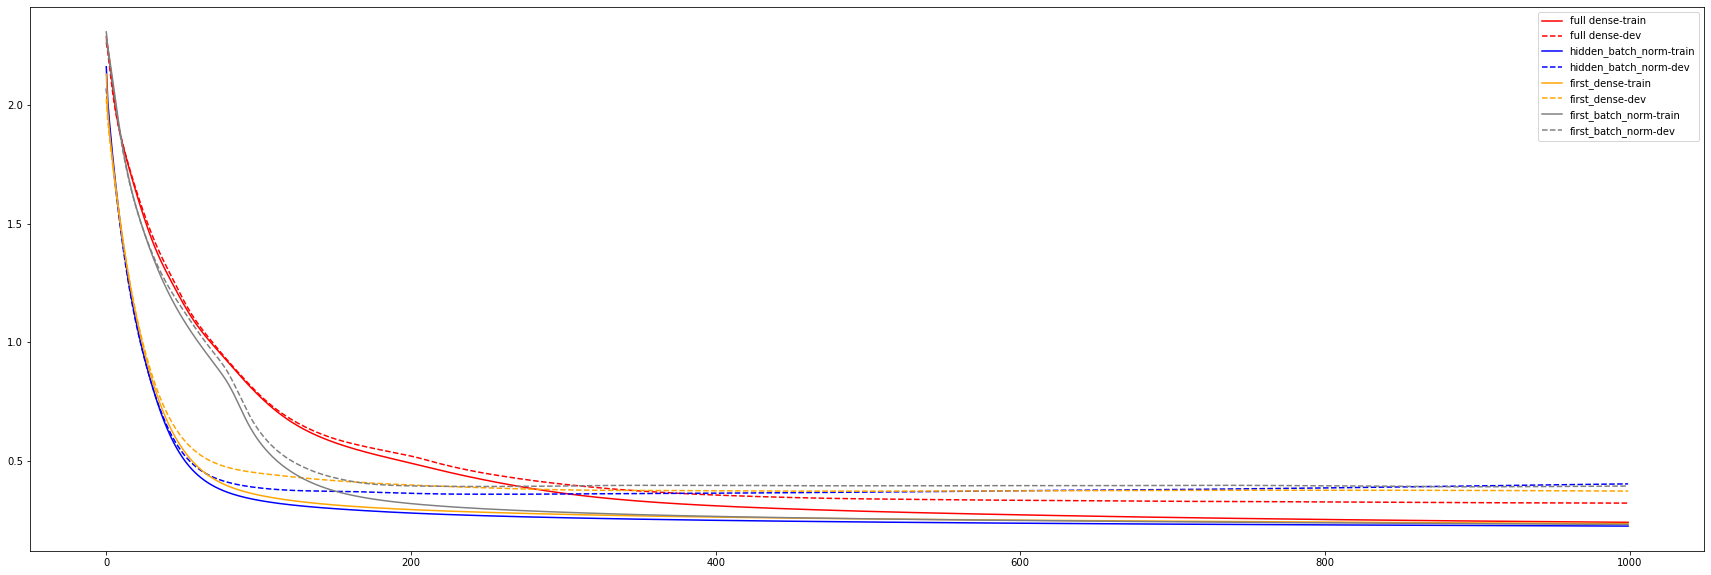

In [201]:
for epoch in range(epochs):
    costs = []
    for model, optimizer in zip(models, optimizers):
        cost_train, cost_dev = model.train(x_batches_train, y_batches_train, x_dev, y_dev, optimizer)
        costs.append(cost_train)
        costs.append(cost_dev)
    
    if epoch % 50 == 0:
        #print('Epoch {0:4d}: cost_train-{1:.7f} cost_dev-{2:.7f}'.format(total_epochs, cost_train, cost_dev))
        print('Epoch {0:4d}'.format(total_epochs))
    total_epochs += 1

    cost_history.append(costs)

plots = np.asarray(cost_history)
plots = np.transpose(plots)
m = plots.shape[1]
plots = np.reshape(plots, [-1,2,m])
models_names = ['full dense', 'hidden_batch_norm', 'first_dense', 'first_batch_norm']
colors = ['red', 'blue', 'orange', 'gray']
for cost_train, cost_dev, name, color in zip(plots[:,0], plots[:,1], models_names, colors):
    plt.plot(cost_train, color=color, label=name+'-train')
    plt.plot(cost_dev, color=color, label=name+'-dev', linestyle='dashed')
plt.rcParams['figure.figsize'] = [30, 10]
plt.legend()
plt.show()

In [159]:
prediction = model.forward(tf.concat(x_batches_train, axis=1))
a = tf.argmax(prediction, axis=0)
y = tf.argmax(tf.concat(y_batches_train, axis=1), axis=0)

b = a==y
b = tf.cast(b, tf.float32)
b = tf.reduce_sum(b)
print(b/10000)

tf.Tensor(0.3493, shape=(), dtype=float32)


In [161]:
x_test = x_batches_train[0]

prediction = model.forward(x_test)
prediction = tf.argmax(prediction, axis=0)

x_test = tf.reshape(x_test, [image_height, image_width, -1])
print(x_test.shape)

(28, 28, 256)


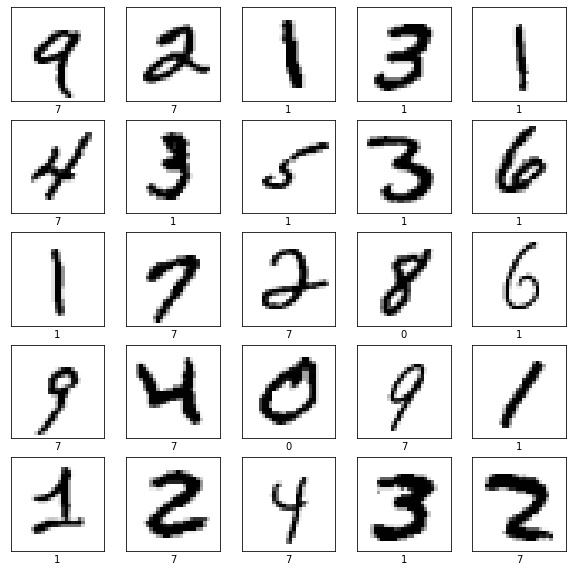

In [162]:
offset = 4

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[:,:, i+offset], cmap=plt.cm.binary)
    plt.xlabel(prediction[i+offset].numpy())
plt.show()